## Perceptual Losses for Real-Time Style Transfer and Super-Resolution

* Johnson et al. - ECCV 2016
* paper: https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf

In [1]:
import os
import time
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

parameters

In [2]:
# default parameters
params = dict()
params['cuda_device_no'] = 3

params['train_flag'] = True
params['model_load_path'] = None

params['vgg_flag'] = 'vgg16'

params['imsize'] = 256
params['cropsize'] = 240
params['image_path'] = '../coco2014/train2014_%d/'%params['imsize']
params['image_name'] = '../coco2014/train.txt'
params['test_image_path'] = 'content_sample.jpg'

params['batch_size'] = 8
params['max_iteration'] = 10000
params['check_point'] = 2000
params['lr'] = 0.1

params['content_weight'] = 1
params['style_weight'] = 30

params['save_path'] = 'trained_models/'

# dependent parameters

## feature layers
if params['vgg_flag'] == 'vgg16':
    params['style_layers'] = [3, 8, 15, 22]
    params['content_layers'] = [15]
elif params['vgg_flag'] == 'vgg19':
    params['style_layers'] = [1, 6, 11, 20, 29]
    params['content_layers'] = [20]
    
## device for gpu or cpu    
device = torch.device('cuda:%d'%params['cuda_device_no']) if params['cuda_device_no'] >= 0 else torch.device('cpu')

## make save path
if not os.path.exists(params['save_path']):
    os.makedirs(params['save_path'])
    print("Make dir : ",params['save_path'])
else:
    print("Exist dir : ",params['save_path'])
    
## save parameters
torch.save(params, params['save_path']+'parameters.pth')

Exist dir :  trained_models/


Networks

In [3]:
class TransformNetwork(nn.Module):    
    def __init__(self):        
        super(TransformNetwork, self).__init__()        
        
        self.layers = nn.Sequential(            
            ConvLayer(3, 32, 9, 1),
            ConvLayer(32, 64, 3, 2),
            ConvLayer(64, 128, 3, 2),
            
            ResidualLayer(128, 128, 3, 1),
            ResidualLayer(128, 128, 3, 1),
            ResidualLayer(128, 128, 3, 1),
            ResidualLayer(128, 128, 3, 1),
            ResidualLayer(128, 128, 3, 1),
            
            DeconvLayer(128, 64, 3, 1),
            DeconvLayer(64, 32, 3, 1),
            ConvLayer(32, 3, 9, 1, activation='linear'),        
        )
        
    def forward(self, x):
        return self.layers(x)
        
class ConvLayer(nn.Module):    
    def __init__(self, in_ch, out_ch, kernel_size, stride, pad='reflect', activation='relu', normalization='instance'):        
        super(ConvLayer, self).__init__()
        
        # padding
        if pad == 'reflect':            
            self.pad = nn.ReflectionPad2d(kernel_size//2)
        elif pad == 'zero':
            self.pad = nn.ZeroPad2d(kernel_size//2)
        else:
            raise NotImplementedError("Not expected pad flag !!!")
    
            
        # convolution
        self.conv_layer = nn.Conv2d(in_ch, out_ch, 
                                    kernel_size=kernel_size,
                                    stride=stride)
        
        # activation
        if activation == 'relu':
            self.activation = nn.ReLU()        
        elif activation == 'linear':
            self.activation = lambda x : x
        else:
            raise NotImplementedError("Not expected activation flag !!!")

        # normalization 
        if normalization == 'instance':            
            self.normalization = nn.InstanceNorm2d(out_ch, affine=True)
        else:
            raise NotImplementedError("Not expected normalization flag !!!")

    def forward(self, x):
        x = self.pad(x)
        x = self.conv_layer(x)
        x = self.normalization(x)
        x = self.activation(x)        
        return x
    
class ResidualLayer(nn.Module):    
    def __init__(self, in_ch, out_ch, kernel_size, stride, pad='reflect', normalization='instance'):        
        super(ResidualLayer, self).__init__()
        
        self.conv1 = ConvLayer(in_ch, out_ch, kernel_size, stride, pad, 
                               activation='relu', 
                               normalization=normalization)
        
        self.conv2 = ConvLayer(out_ch, out_ch, kernel_size, stride, pad, 
                               activation='linear', 
                               normalization=normalization)
        
    def forward(self, x):
        y = self.conv1(x)
        return self.conv2(y) + x
        
class DeconvLayer(nn.Module):    
    def __init__(self, in_ch, out_ch, kernel_size, stride, pad='reflect', activation='relu', normalization='instance', upsample='nearest'):        
        super(DeconvLayer, self).__init__()
        
        # upsample
        self.upsample = upsample
        
        # pad
        if pad == 'reflect':            
            self.pad = nn.ReflectionPad2d(kernel_size//2)
        elif pad == 'zero':
            self.pad = nn.ZeroPad2d(kernel_size//2)
        else:
            raise NotImplementedError("Not expected pad flag !!!")        
        
        # conv
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride)
        
        # activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'linear':
            self.activation = lambda x : x
        else:
            raise NotImplementedError("Not expected activation flag !!!")
        
        # normalization
        if normalization == 'instance':
            self.normalization = nn.InstanceNorm2d(out_ch, affine=True)
        else:
            raise NotImplementedError("Not expected normalization flag !!!")
        
    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=2, mode=self.upsample)        
        x = self.pad(x)
        x = self.conv(x)
        x = self.normalization(x)        
        x = self.activation(x)        
        return x

image loader

In [4]:
imsize = params['imsize']
cropsize = params['cropsize']

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])

unloader = transforms.ToPILImage()

train_transformer = transforms.Compose([
    transforms.Resize(imsize),
    transforms.RandomCrop((cropsize, cropsize)),
    transforms.ToTensor(),
    normalize    
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_path, file_names, transform=train_transformer):        
        super(Dataset, self).__init__()
        
        self.file_names = [name.strip() for name in open(file_names).readlines()]
        self.root_path = root_path        
        self.transform = transform
        
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.root_path + self.file_names[index])).convert("RGB")
        return self.transform(image)
    
def imshow(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    tensor = torchvision.utils.make_grid(tensor)    
    tensor = denormalize(tensor)
    image = unloader(tensor.clamp_(0.0, 1.0))
    plt.imshow(image)
    plt.show()
    return None

def imsave(tensor, path):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    tensor = torchvision.utils.make_grid(tensor)    
    torchvision.utils.save_image(denormalize(tensor).clamp_(0.0, 1.0), path)
    return None
    
def imload(path, imsize=256):
    transform_ = list()
    transformer = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor(),
        normalize
    ])
    return transformer(Image.open(path)).unsqueeze(0)

def extract_features(model, x, layers):
    features = list()
    for index, layer in enumerate(model):
        x = layer(x)
        if index in layers:
            features.append(x)
    return features

def gram(x):
    b ,c, h, w = x.size()
    g = torch.bmm(x.view(b, c, h*w), x.view(b, c, h*w).transpose(1,2))
    return g.div(h*w)

functions for training

In [5]:
mse_criterion = torch.nn.MSELoss(reduction='mean')

def calc_Content_Loss(features, targets, weights=None):
    if weights is None:
        weights = [1/len(features)] * len(features)
    
    content_loss = 0
    for f, t, w in zip(features, targets, weights):
        content_loss += mse_criterion(f, t) * w
        
    return content_loss

def calc_Gram_Loss(features, targets, weights=None):
    if weights is None:
        weights = [1/len(features)] * len(features)
        
    gram_loss = 0
    for f, t, w in zip(features, targets, weights):
        gram_loss += mse_criterion(gram(f), gram(t)) * w
    return gram_loss

def calc_TV_Loss(x):
    tv_loss = torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]))
    tv_loss += torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    return tv_loss

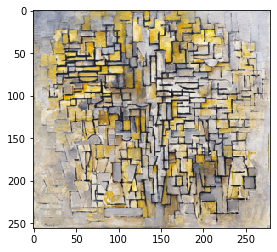

In [6]:
target_style = imload("../test-image-dataset/style-images/mondrian.jpg").to(device)
imshow(target_style)

### train

Fri Aug  9 01:42:49 2019: Loss Graph


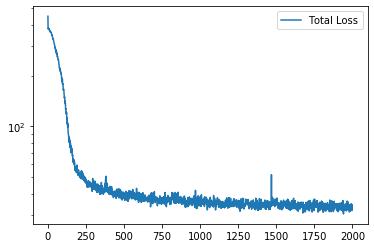

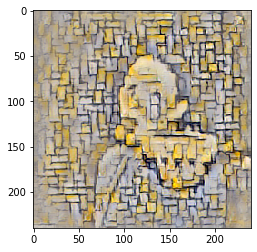

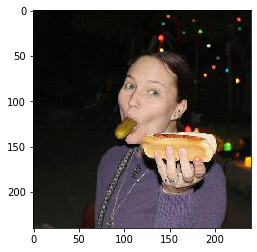

Fri Aug  9 01:55:57 2019: Loss Graph


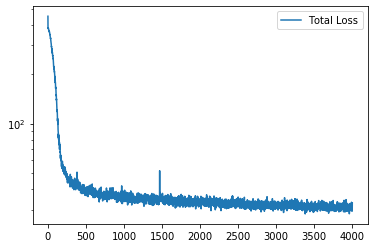

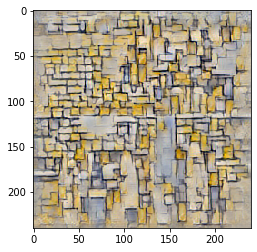

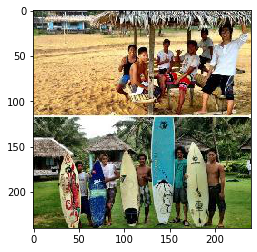

Fri Aug  9 02:09:04 2019: Loss Graph


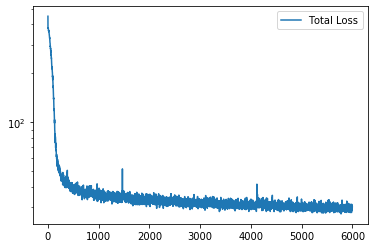

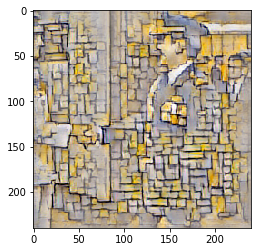

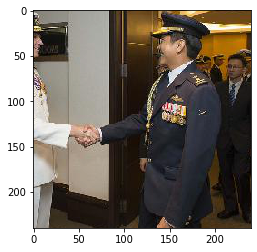

Fri Aug  9 02:22:04 2019: Loss Graph


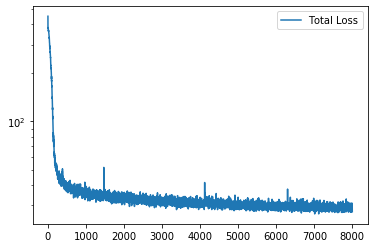

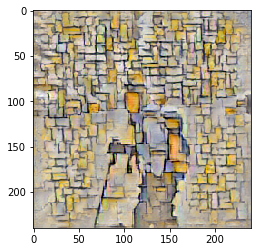

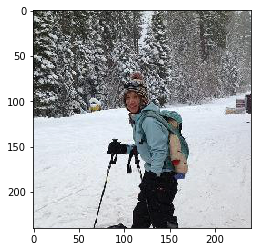

In [7]:
# network
transform_network = TransformNetwork().to(device)
if params['model_load_path']:
    transform_network.load_state_dict(torch.load(params['model_load_path']))
    print("Model loaded from : ",params['model_load_path'])

if params['train_flag']:
    # data set
    train_dataset = Dataset(params['image_path'], params['image_name'], train_transformer)    
    
    # loss network
    loss_network = models.__dict__[params['vgg_flag']](pretrained=True).features.to(device)
    
    # optimizer
    optimizer = torch.optim.Adam(params=transform_network.parameters(), lr=params['lr'])
    
    # expand batch size
    b, c, h, w = target_style.size()
    target_style = target_style.expand(params['batch_size'], c, h, w)

    # training
    loss_logs = list()
    for iteration in range(1, params['max_iteration']):
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, pin_memory=True)
        input_image = next(iter(train_loader)).to(device)

        # stylized output image
        output_image = transform_network(input_image)

        # target content feature
        target_content_features = extract_features(loss_network, input_image, params['content_layers'])

        # target style features
        target_style_features = extract_features(loss_network, target_style, params['style_layers'])

        # output features
        output_content_features = extract_features(loss_network, output_image, params['content_layers'])
        output_style_features = extract_features(loss_network, output_image, params['style_layers'])

        # calulate total loss
        content_loss = calc_Content_Loss(output_content_features, target_content_features)
        style_loss = calc_Gram_Loss(output_style_features, target_style_features)
        total_loss = content_loss * params['content_weight'] + style_loss * params['style_weight']

        # loging loss
        loss_logs.append(total_loss.item())

        # optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if iteration % params['check_point'] == 0:
            print("%s: Loss Graph"%time.ctime())
            plt.semilogy(loss_logs, label='Total Loss')
            plt.legend()
            plt.show()

            imshow(output_image[0])
            plt.show()

            imshow(input_image[0])
            plt.show()

            imsave(output_image[0], params['save_path']+'iteration_%d_output.jpg'%(iteration))
            imsave(input_image[0], params['save_path']+"iteration_%d_input.jpg"%(iteration))                        

            torch.save(transform_network.state_dict(), params['save_path']+"network.pth")                
    torch.save(transform_network.state_dict(), params['save_path']+"network.pth")
else:
    test_input = imload(params['test_image_path'], imsize=params['imsize']).to(device)
    output = transform_network(test_input)
    
    imsave(output, params['save_path']+"test_output.jpg")

In [9]:
test_input = imload(params['test_image_path']).to(device)
test_output = transform_network(test_input)

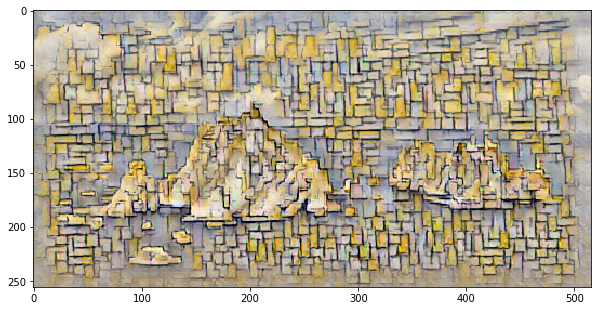

In [10]:
plt.figure(figsize=(10,10))
imshow(test_output)